<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Format" data-toc-modified-id="Format-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Format</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Filtering</a></span></li></ul></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Tree-subsample" data-toc-modified-id="Tree-subsample-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tree subsample</a></span></li><li><span><a href="#RRPP" data-toc-modified-id="RRPP-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>RRPP</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* RRPP analysis to assess correlations of OTUs and host phenotypes while controlling for host phylogeny
* Just assessing Methanobrevibacter ASVs versus body temperature

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/'

# microbiome
## 16S-arch phyloseq object (one sample per individual)
physeq_arch_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_IndD_rare250.RDS'

# host tree
host_tree_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch_IndD.nwk'

# body temp data
Tb_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged//bodyTemp_all.tsv'

# misc params
threads = 12
my_seed = 8394

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)

library(ape)
library(phyloseq)
library(RRPP)

library(doParallel)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘RRPP’


The following object is masked from ‘package:phyloseq’:

    ordinate


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# cluster job submission
#clustermq_setup()
#library(clustermq)

In [4]:
df.dims()
set.seed(my_seed)
make_dir(work_dir)
RhpcBLASctl::blas_set_num_threads(1)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/ 


# Load

In [5]:
# phyloseq obj.
physeq = readRDS(physeq_arch_IndD_file) %>%
    subset_taxa(Order == 'Methanobacteriales') %>%
    filter_taxa(function(x) sum(x > 0) >= 2, TRUE) %>%
    prune_samples(sample_sums(.) > 0, .) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 188 taxa and 179 samples ]
sample_data() Sample Data:       [ 179 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 188 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 188 tips and 187 internal nodes ]

In [6]:
# otus per genus table
otu = physeq %>%
    phyloseq2df(otu_table, long=TRUE) %>%
    inner_join(phyloseq2df(physeq, tax_table),
               c('OTU')) %>%
    mutate(Taxonomy = paste(Domain, Phylum, Class, Order, Family, Genus, sep=';')) %>%
    group_by(Sample, Taxonomy) %>%
    summarize(Count = sum(Count > 0), .groups='drop') %>%
    spread(Taxonomy, Count) %>%
    as.data.frame
rownames(otu) = otu$Sample
otu$Sample = NULL
otu

,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanosphaera,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;unclassified,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter
,<int>,<int>,<int>,<int>,<int>
F14_Common_Bream,4,1,0,0,0
F157a_European_Toad,0,1,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮
X94_Mangalica,0,3,0,0,2
X96_European_Hare,0,1,4,0,1


In [7]:
# host phylogeny
host_tree = read.tree(host_tree_IndD_file)
host_tree


Phylogenetic tree with 185 tips and 184 internal nodes.

Tip labels:
	X60_European_Chub, X179_Roach, X330_Ide, X327_Silver_Bream, X326_Silver_Bream, F14_Common_Bream, ...
Node labels:
	, @_20_@, @_17_@, @_14_@, @_9_@, @_15_@, ...

Rooted; includes branch lengths.

In [8]:
# metadata
metadata = physeq %>% 
    phyloseq2df(sample_data) %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name),
           digestive_system = gsub('fermentation activity ', '', digestive_system),
           dig_sys = gsub('simple ', '', digestive_system)) %>%
    as.data.frame
rownames(metadata) = metadata$SampleID
metadata 

,SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.d_mean,i.CH4_L.d_sd,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
F14_Common_Bream,F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,F14_Common_Bream,simple
F35_Red_Deer,F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,52.24132,27.18306,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X405_Nile_Crocodile,X405_Nile_Crocodile,405,Nilkrokodil,Nile.Crocodile,Crocodylus_niloticus,NA,8501,Reptilia,Crocodilia,Crocodylidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X405_Nile_Crocodile,simple
X67_European_Roe,X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X67_European_Roe,foregut


In [9]:
# body temp
metadata = metadata %>%
    inner_join(read.delim(Tb_file) %>% 
                   dplyr::select(scientific_name, dataset, Tb) %>%
                   mutate(scientific_name = gsub(' ', '_', scientific_name)),
               c('scientific_name')) %>%
    rename('dataset_Tb' = dataset)

metadata %>% .$Tb %>% summary_x
metadata 

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
.,30.7,37.4,38.6,38.27883,39.5,41.9,42,3.802,1.437


SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys,dataset_Tb,Tb
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,F14_Common_Bream,simple,NA,NA
F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut,WalzerXXXX,38.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X405_Nile_Crocodile,405,Nilkrokodil,Nile.Crocodile,Crocodylus_niloticus,NA,8501,Reptilia,Crocodilia,Crocodylidae,⋯,NA,NA,NA,NA,NA,NA,X405_Nile_Crocodile,simple,NA,NA
X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,X67_European_Roe,foregut,WalzerXXXX,40.4


## Format

In [10]:
vars = c('Tb')
otu = cbind(metadata[,vars, drop=FALSE], otu)
otu

,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanosphaera,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;unclassified,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter
,<dbl>,<int>,<int>,<int>,<int>,<int>
F14_Common_Bream,NA,4,1,0,0,0
F157a_European_Toad,38.6,0,1,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
X94_Mangalica,NA,0,3,0,0,2
X96_European_Hare,40.4,0,1,4,0,1


## Filtering

In [11]:
# filtering otu
otu = otu[!is.na(otu$Tb),]
otu$Tb %>% summary
otu

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.70   37.40   38.60   38.28   39.50   41.90 

,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanosphaera,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;unclassified,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter
,<dbl>,<int>,<int>,<int>,<int>,<int>
F157a_European_Toad,38.6,0,1,0,0,0
F35_Red_Deer,38.6,0,8,4,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
X93_Red_Sheep,37.0,0,17,1,0,9
X96_European_Hare,40.4,0,1,4,0,1


In [12]:
# filtering tree
to_rm = setdiff(host_tree$tip.label, rownames(otu))
host_tree = ape::drop.tip(host_tree, to_rm)
host_tree


Phylogenetic tree with 137 tips and 136 internal nodes.

Tip labels:
	X179_Roach, X330_Ide, X125_Common_Carp, X350_Smooth_Newt, X349_Smooth_Newt, X194_Agile_Frog, ...
Node labels:
	, @_20_@, @_14_@, @_197_@, @_28_@, NA, ...

Rooted; includes branch lengths.

In [13]:
# checking overlap
overlap(host_tree$tip.label, rownames(otu))

intersect(x,y): 137 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 137 


# Plotting

In [14]:
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))
tax

Domain,Phylum,Class,Order,Family,Genus,Species,OTU
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,b9654a42cc8eefb1cbb0daba005335ff
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,X_5cd4fe5cb79cdf4841549e580ea5a27f
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,X_36fd5c55ad082f4d05194157da9d13da
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Haemonchus placei,d7dd0bdd8184f8cb7189e1e09afa97d0


In [15]:
# joining
otu_j = otu %>%
    mutate(Sample = rownames(.)) %>%
    gather(OTU, richness, -Tb, -Sample) %>%
    dplyr::select(-Tb) %>%
    inner_join(metadata, c('Sample'='SampleID')) %>%
    filter(!is.na(Tb))
otu_j

Sample,OTU,richness,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,⋯,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample.y,dig_sys,dataset_Tb,Tb
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
F35_Red_Deer,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium,0,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,⋯,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut,WalzerXXXX,38.6
F36_Red_Deer,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium,0,F36,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,⋯,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F36_Red_Deer,foregut,WalzerXXXX,38.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X88_European_Rabbit,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter,1,88,Wildkaninchen,European.Rabbit,Oryctolagus_cuniculus,NA,9986,Mammalia,⋯,0.1876504,0.08941013,0.6779272,0.6824092,35.24621,35.47923,X88_European_Rabbit,hindgut,WalzerXXXX,38.4
X93_Red_Sheep,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter,9,93,Hausschaf,Red.Sheep,Ovis_aries,NA,9940,Mammalia,⋯,0.5260416,0.17857864,21.6593240,7.1809034,1161.10184,377.62696,X93_Red_Sheep,foregut,WalzerXXXX,39.2


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



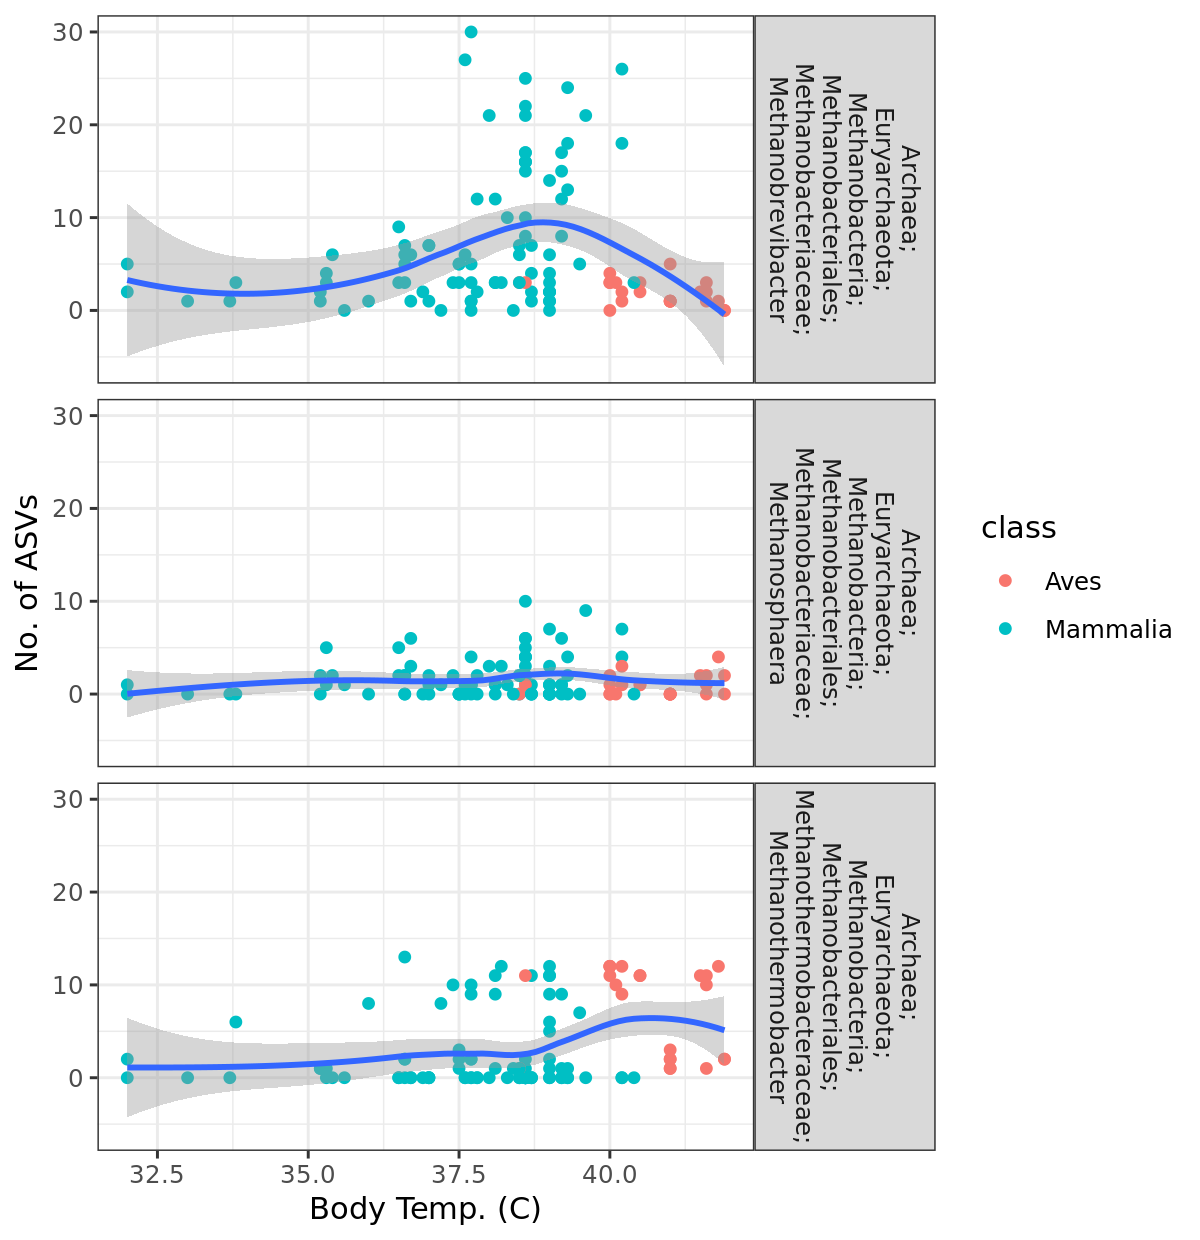

In [16]:
# plotting
p = otu_j %>%
    group_by(OTU) %>%
    mutate(mean_r = mean(richness)) %>%
    ungroup() %>%
    filter(mean_r > 1) %>%
    mutate(OTU = gsub(';', '; ', OTU),
           OTU = stringr::str_wrap(OTU, 20)) %>%
    ggplot(aes(Tb, richness)) +
    geom_point(aes(color=class)) +
    geom_smooth() +
    labs(x='Body Temp. (C)', y='No. of ASVs') +
    facet_grid(OTU ~ .) +
    theme_bw()

p.dims(6,6.2)
plot(p)

# Tree subsample

In [17]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [18]:
# replicate analyses with different subsets of the host phylogeny
n_reps = 100

In [19]:
# permuted trees
df = metadata %>%
    mutate(sample = SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:n_reps), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

# RRPP

In [20]:
.rrpp_per = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                Tb = otu_f$Tb)
    names(data[['Tb']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ Tb, data = data, Cov = PhyCov,
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_per = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        plyr::llply(.rrpp_per, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [21]:
#running for all OTUs & all trees
taxa = colnames(otu)[2:ncol(otu)]
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_per, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    filter(feature == 'Tb')
rrpp_res

Number of OTUs: 5 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,2.382818e-05,2.382818e-05,5.009303e-05,0.003907452,-1.980612,0.949,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium
1,7.728774e-06,7.728774e-06,1.624762e-05,0.001316079,-1.893158,0.952,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.1992675,0.1992675,0.006180562,0.4913009,0.2775288,0.472,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter
1,0.5091536,0.5091536,0.014796440,1.2014931,0.6860996,0.265,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter


## Summary

In [22]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$P %>% summary_x('P')
rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
P,0.58,0.6,0.9,0.814,0.99,1,0.186,0.076


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,1,1,1,1,1,1,0,0


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,2.382818e-05,2.382818e-05,5.009303e-05,0.003907452,-1.980612,1,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium,1
1,7.728774e-06,7.728774e-06,1.624762e-05,0.001316079,-1.893158,1,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobacterium,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.1992675,0.1992675,0.006180562,0.4913009,0.2775288,0.99,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter,1
1,0.5091536,0.5091536,0.014796440,1.2014931,0.6860996,0.99,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanothermobacteraceae;Methanothermobacter,1


In [23]:
rrpp_res_s %>%
    filter(P < 0.6)

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,2.169711,2.169711,0.03429613,2.770102,1.021326,0.58,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,1
1,8.470209,8.470209,0.16455951,15.954841,1.813814,0.58,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.1170897,0.1170897,0.002085743,0.1651181,-0.242383,0.58,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,1
1,2.6092111,2.6092111,0.056673728,4.8062885,1.224582,0.58,Tb,Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,1


In [24]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


# sessionInfo

In [25]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-physig/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] LeyLabRMisc_0.1.6 doParallel_1.0.15 iterators_1.0.12  foreach_1.5.0    
 [5] RRPP_0.6.0        phyloseq_1.32.0   ape_5.4           ggplot2_3.3.1    
 [9] tidyr_1.1.0       dplyr_1.0.0      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6      